## Import our libraries

In [1]:
%matplotlib inline
import numpy as np
#for the sigmoid function we need expit() from scipy
import scipy.special
#library for plotting arrays
import matplotlib.pyplot as plt
# A particularly interesting backend, provided by IPython, is the inline backend. 
# This is available only for the Jupyter Notebook and the Jupyter QtConsole. 
# It can be invoked as follows: %matplotlib inline
# With this backend, the output of plotting commands is displayed inline 
# within frontends like the Jupyter notebook, directly below the code cell that produced it. 
# The resulting plots are inside this notebook, not an external window.

import pandas as pd # to manage data frames and reading csv files

## Set our Global Variables
later you will need to modify these to present your solution to the Exercise

In [2]:
#number of input, hidden and output nodes
input_nodes = 784 #we have a 28x28 matrix to describe each digit
hidden_nodes = 200
output_nodes = 10

learning_rate = 0.3
batch_size = 1 # increase this if you want batch gradient descent

# epochs is the number of training iterations 
epochs = 10

# datasets to read
# you can change these when trying out other datasets
train_file = "mnist_train.csv"
test_file = "mnist_test.csv"

## Specify our Dataset for Classification
Note we have indicated a train set for model training and test set for testing the learned model

## MNIST dataset
The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems.
The database is also widely used for training and testing in the field of machine learning.
It was created by "re-mixing" the samples from NIST's original datasets. 
The creators felt that since NIST's training dataset was taken from American Census Bureau employees, while the testing dataset was taken from American high school students, it was not well-suited for machine learning experiments.
Furthermore, the black and white images from NIST were normalized to fit into a 28x28 pixel bounding box and anti-aliased, which introduced grayscale levels.
<img src="mnist.png">
 
The MNIST database contains 60,000 training images and 10,000 testing images.
Half of the training set and half of the test set were taken from NIST's training dataset, while the other half of the training set and the other half of the test set were taken from NIST's testing dataset.
There have been a number of scientific papers on attempts to achieve the lowest error rate; one paper, using a hierarchical system of convolutional neural networks, manages to get an error rate on the MNIST database of 0.23 percent.
The original creators of the database keep a list of some of the methods tested on it.
In their original paper, they use a support vector machine to get an error rate of 0.8 percent.

### MINIST for the lab
Our training and test set contains 60K and 10K instances.
You might want to load the smaller of these csv files into a spreadsheet and have a look at it. 
Note that each row specifies a single handwritten digit as a flat structure. 
The first value is the class of the digit. 
To actual view this digit we need to un-flatten the numbers in a given row and turn it into a 28x28 matrix.
We will do this next.

To reduce the time taken for training we can use a smaller random sample during our lab. 

Lets use the pandas library to have a look at an instance in the MNIST dataset below.

You can change the idx value to access different instances (example below accesses the 21st indexed instance)


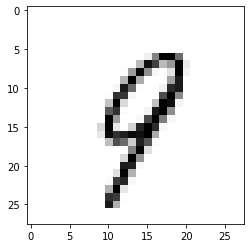

In [3]:
#read the file into a pandas frame
df = pd.read_csv(train_file) 

#get a specific instance and read values other than position 1 e.g. slice using 1:
idx = 21
instance = df.iloc[idx:(idx+1), 1:].values

# now reshape the 784 features into a 28x28 grid
# here asfarray helps to convert values into real numbers
image_array = np.asfarray(instance).flatten().reshape((28,28))

# print the grid in grey scale
plt.imshow(image_array, cmap='Greys', interpolation='None') 

In [4]:
#load the mnist training data CSV file into a list
#train_data_file = open("mnist/mnist_train_100.csv", 'r') # open and read the 100 instances in the text file
train_data_file = open(train_file, 'r')
train_data_list = train_data_file.readlines() # read all lines into memory 
train_data_file.close() 
print("train set size: ", len(train_data_list))

#testing the network
#load the mnist test data CSV file into a list
test_data_file = open(test_file, 'r') # read the file 
test_data_list = test_data_file.readlines()
test_data_file.close()
print("test set size: ", len(test_data_list))

train set size:  60000
test set size:  10000


## Build our Artificial Neural Network class
Some of the key methods include:

- __init__ : initialisation method to set all the class variables
- train : this is the method that implments the forward and back ward pass as well as updating the wights. You should study the weight update lines to understand ; which values actually contribute to the modification of weights. Note there are two sets of weights - wih are wwights from input to hidden nodes; and who weights from hidden to output nodes.
- test: this takes a set in test instances and queries the network to obtain a prediction which can then be compared against the expected target class to compute accuracy

Some of the key hyper-parameters include:
- ep (epoch) which is the number of training iterations on the full dataset); 
- lr (learning rate) the amount of moderation used to manage by how much we adjust the weights
- batch_size the number of examples considered within a single epoch before updating network parameters; 
- hnodes (hidden nodes) the number of hidden layer nodes


In [67]:
class neuralNetwork:
    """Artificial Neural Network classifier.

    Parameters
    ------------
    lr : float
      Learning rate (between 0.0 and 1.0)
    ep : int
      Number of epochs
    bs : int
      Size of the training batch to be used when calculating the gradient descent. 
      batch_size = 1 standard gradient descent
      batch_size > 1 stochastic gradient descent 

    inodes : int
      Number of input nodes which is normally the number of features in an instance.
    hnodes : int
      Number of hidden nodes in the net.
    onodes : int
      Number of output nodes in the net.


    Attributes
    -----------
    wih : 2d-array
      Input2Hidden node weights after fitting 
    who : 2d-array
      Hidden2Output node weights after fitting 
    E : list
      Sum-of-squares error value in each epoch.
      
    Results : list
      Target and predicted class labels for the test data.
      
    Functions
    ---------
    activation_function : float (between 1 and -1)
        implments the sigmoid function which squashes the node input

    """

    def __init__(self, inputnodes=784, hiddennodes=200, outputnodes=10, learningrate=0.1, batch_size=1, epochs=10, compare_enabled=False):
        self.inodes = inputnodes
        self.hnodes = hiddennodes
        self.onodes = outputnodes
        
        #two weight matrices, wih (input to hidden layer) and who (hidden layer to output)
        #a weight on link from node i to node j is w_ij
        
        
        #Draw random samples from a normal (Gaussian) distribution centered around 0.
        #numpy.random.normal(loc to centre gaussian=0.0, scale=1, size=dimensions of the array we want) 
        #scale is usually set to the standard deviation which is related to the number of incoming links i.e. 
        #1/sqrt(num of incoming inputs). we use pow to raise it to the power of -0.5.
        #We have set 0 as the centre of the guassian dist.
        # size is set to the dimensions of the number of hnodes, inodes and onodes for each weight matrix
        self.wih = np.random.normal(0.0, pow(self.inodes, -0.5), (self.hnodes, self.inodes))
        self.who = np.random.normal(0.0, pow(self.onodes, -0.5), (self.onodes, self.hnodes))
        
        #set the learning rate
        self.lr = learningrate
        
        #set the batch size
        self.bs = batch_size
        
        #set the number of epochs
        self.ep = epochs
        
        #store errors at each epoch
        self.E= []
        
        #store results from testing the model
        #keep track of the network performance on each test instance
        self.results= []
        #forhiddennode comparsion
        self.before_act = []
        self.after_act = []
        
        #define the activation function here
        #specify the sigmoid squashing function. Here expit() provides the sigmoid function.
        #lambda is a short cut function which is executed there and then with no def (i.e. like an anonymous function)
        self.activation_function = lambda x: scipy.special.expit(x)
        self.compare_enabled = compare_enabled
        pass
    
    # function to help management of batching for gradient descent
    # size of the batch is controled by self,bs
    def batch_input(self, X, y): # (self, train_inputs, targets):
        """Yield consecutive batches of the specified size from the input list."""
        for i in range(0, len(X), self.bs):
            # yield a tuple of the current batched data and labels
            yield (X[i:i + self.bs], y[i:i + self.bs])
    
    #train the neural net
    #note the first part is very similar to the query function because they both require the forward pass
    def train(self, train_inputs, targets_list):
    #def train(self, train_inputs):
        """Training the neural net. 
           This includes the forward pass ; error computation; 
           backprop of the error ; calculation of gradients and updating the weights.

            Parameters
            ----------
            train_inputs : {array-like}, shape = [n_instances, n_features]
            Training vectors, where n_instances is the number of training instances and
            n_features is the number of features.
            Note this contains all features including the class feature which is in first position
        
            Returns
            -------
            self : object
        """
      
        for e in range(self.ep):
            print("Training epoch#: ", e)
            sum_error = 0.0   
            for (batchX, batchY) in self.batch_input(train_inputs, targets_list):
                #creating variables to store the gradients   
                delta_who = 0
                delta_wih = 0
                
                # iterate through the inputs sent in
                for inputs, targets in zip(batchX, batchY):
                    #convert  inputs list to 2d array
                    inputs = np.array(inputs,  ndmin=2).T
                    targets = np.array(targets, ndmin=2).T

                    #calculate signals into hidden layer
                    hidden_inputs = np.dot(self.wih, inputs)
                    #calculate the signals emerging from the hidden layer
                    hidden_outputs = self.activation_function(hidden_inputs)

                    #calculate signals into final output layer
                    final_inputs=np.dot(self.who, hidden_outputs)
                    #calculate the signals emerging from final output layer
                    final_outputs = self.activation_function(final_inputs)
        
                    #to calculate the error we need to compute the element wise diff between target and actual
                    output_errors = targets - final_outputs
                    #Next distribute the error to the hidden layer such that hidden layer error
                    #is the output_errors, split by weights, recombined at hidden nodes
                    hidden_errors = np.dot(self.who.T, output_errors)
                                  
                    ## for each instance accumilate the gradients from each instance
                    ## delta_who are the gradients between hidden and output weights
                    ## delta_wih are the gradients between input and hidden weights
                    delta_who += np.dot((output_errors * final_outputs * (1.0 - final_outputs)), np.transpose(hidden_outputs))
                    delta_wih += np.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), np.transpose(inputs))
                    
                    sum_error += np.dot(output_errors.T, output_errors)#this is the sum of squared error accumilated over each batced instance
                   
                pass #instance
            
                # update the weights by multiplying the gradient with the learning rate
                # note that the deltas are divided by batch size to obtain the average gradient according to the given batch
                # obviously if batch size = 1 then we simply end up dividing by 1 since each instance forms a singleton batch
                self.who += self.lr * (delta_who / self.bs)
                self.wih += self.lr * (delta_wih / self.bs)
            pass # batch
            self.E.append(np.asfarray(sum_error).flatten())
            print("errors (SSE): ", self.E[-1])
        pass # epoch
    
    #query the neural net
    def query(self, inputs_list):
        #convert inputs_list to a 2d array
        inputs = np.array(inputs_list, ndmin=2).T 
                
        #propogate input into hidden layer. This is the start of the forward pass
        hidden_inputs = np.dot(self.wih, inputs)
        
        #squash the content in the hidden node using the sigmoid function (value between 1, -1)
        hidden_outputs = self.activation_function(hidden_inputs)
        
        if self.compare_enabled:
            self.before_act.append(hidden_inputs)
            self.after_act.append(hidden_outputs)
                
        #propagate into output layer and the apply the squashing sigmoid function
        final_inputs = np.dot(self.who, hidden_outputs)
        
        final_outputs = self.activation_function(final_inputs)
        return final_outputs
    
     
    #iterate through all the test data to calculate model accuracy
    def test(self, test_inputs, test_targets):
        self.results = []
        
        #go through each test instances
        for inputs, target in zip(test_inputs, test_targets):
            #query the network with test inputs
            #note this returns 10 output values ; of which the index of the highest value
            # is the networks predicted class label
            outputs = self.query(inputs)
            #get the target which has 0.99 as highest value corresponding to the actual class
            target_label = np.argmax(target)
            #get the index of the highest output node as this corresponds to the predicted class
            predict_label = np.argmax(outputs) #this is the class predicted by the ANN
        
            self.results.append([predict_label, target_label])
            pass
        pass
        self.results = np.asfarray(self.results) # flatten results to avoid nested arrays

    

## Helper functions to preprocess the data

In [6]:
# preprocess the data directly read from the csv file
# we want to maintain inputs (X) and targets (y) seperatly
def preprocess_data(Xy):
    X=[]
    y=[]
    for instance in Xy:
        # split the record by the ',' commas
        all_values = instance.split(',')
        # scale and shift the inputs
        inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
        # create the target output values (all 0.01, except the desired label which is 0.99)
        targets = np.zeros(output_nodes) + 0.01
        # all_values[0] is the target label for this record
        targets[int(all_values[0])] = 0.99
        X.insert(len(X), inputs)
        #print(len(y), targets)
        y.insert(len(y), targets)
    pass
    return(X,y)
pass

In [7]:
# numpy.random.choice generates a random sample from a given 1-D array
# we can use this to select a sample from our training data in case we want to work with a small sample
# for instance we use a small sample here such as 1500 instead of the larger 6000 instances
mini_training_data = np.random.choice(train_data_list, 1500, replace = False)
print("Percentage of training data used:", (len(mini_training_data)/len(train_data_list)) * 100)

X_train, y_train = preprocess_data(mini_training_data)
X_test, y_test = preprocess_data(test_data_list)

Percentage of training data used: 2.5


## Train the Artificial Neural Net

In [8]:
#create instance of neuralnet
n = neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate, batch_size, epochs)

n.train(X_train, y_train)

Training epoch#:  0
errors (SSE):  [532.25677936]
Training epoch#:  1
errors (SSE):  [205.62996352]
Training epoch#:  2
errors (SSE):  [114.74834313]
Training epoch#:  3
errors (SSE):  [63.29395608]
Training epoch#:  4
errors (SSE):  [36.55929664]
Training epoch#:  5
errors (SSE):  [22.66016507]
Training epoch#:  6
errors (SSE):  [15.64642201]
Training epoch#:  7
errors (SSE):  [11.96041421]
Training epoch#:  8
errors (SSE):  [9.60309394]
Training epoch#:  9
errors (SSE):  [7.94844275]


## Plot the model error with increasing epochs

Error at the end of each epoch has been stored in self.E
We can now use mathplotlib to plot the error at the end of each epoch. 
Our expectation is that as we continue to descend (hill-walking) we should move closer to the minima
as such error should decrease. 

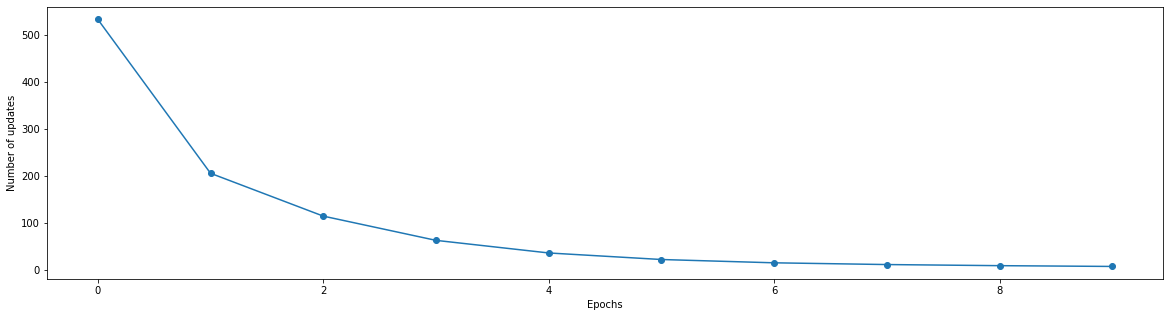

In [9]:
#print the error over epochs

plt.figure(figsize=(20,5)) #width, height settings for figures
plt.plot(range(0, n.ep), np.asfarray(n.E), marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of updates')

# plt.savefig('images/02_07.png', dpi=300)
plt.show()

## Test the ANN and compute the Accuracy
We will keep track of the predicted and actual outputs in order to 
calculate the accuracy of the model on the unseen test data. 


In [10]:
n.test(X_test, y_test)
#print network performance as an accuracy metric
correct = 0 # number of predictions that were correct

#iteratre through each tested instance and accumilate number of correct predictions
for result in n.results:
    if (result[0] == result[1]):
            correct += 1
    pass
pass

# print the accuracy on test set
print ("Test set accuracy% = ", (100 * correct / len(n.results)))

Test set accuracy% =  92.7


## Exploring different values of a hyperparameter - a comparative study on the batch_size
Often we need to explore a variety of values for an algorithms hyper parameters before we can suggest the best model. For instance with the ANN we can study the accuracy by changing the number of epochs, or the batch_size or learning rate , for instance. 

Lets look at what happens when the batch size 
- batch_size = size of training data; we adopt the Batch Gradient Decent (BGD) approach to optimisaing the ANN's weights. This means that the weights are updated once at each epoch (= pass over the training dataset). The amount by which we update is an aggregation over all the training instances. 
- batch_size = 1, we adopt the Stochastic Gradient Descent (SGD) optimisation approach to updating weights. SGD is sometimes also referred to as iterative or on-line Gradient Decent (GD). In a given epoch we update the weights many times for each instance in the training set. That is to say that we check the error with each training instance; compute the gradient and update the weights. As such we don't accumulate the weight updates as we do with GD. The frequent updates immediately give an insight into the performance of the model and the rate of improvement. But updating the model so frequently is more computationally expensive than other configurations of gradient descent, taking significantly longer to train models on large datasets. Here, the term "stochastic" comes from the fact that the gradient based on a single training sample is a "stochastic approximation" of the "true" cost gradient. Due to its stochastic nature, the path towards the global cost minimum is not "direct" as in BGD, but may go "zig-zag" if we are visualizing the cost surface in a 2D space. However, it has been shown that SGD although is time consuming is more likely to converge to the global cost minimum.
- batch_size >1 and < len(training data); this will be an inbetween mini-batch approach to updating the weights. 




In [11]:
# numpy.random.choice generates a random sample from a given 1-D array
# we can use this to select a sample from our training data in case we want to work with a small sample
# for instance we use a small sample here such as 1500
mini_training_data = np.random.choice(train_data_list, 1500, replace = False)
print("Percentage of training data used:", (len(mini_training_data)/len(train_data_list)) * 100)
X_train, y_train = preprocess_data(mini_training_data)

print("This will take a few moments ...")
n_list = []
batch_sizes = [1, 20, 100, 200, 500, len(mini_training_data)]

for batch_size in batch_sizes:
    n = neuralNetwork(batch_size=batch_size) # create a new ANN model with a specific batch size
    n.train(X_train, y_train)
    n_list.append(n) # maintain each ANN model in a list
    

Percentage of training data used: 2.5
This will take a few moments ...
Training epoch#:  0
errors (SSE):  [514.05821096]
Training epoch#:  1
errors (SSE):  [240.9600352]
Training epoch#:  2
errors (SSE):  [168.26594226]
Training epoch#:  3
errors (SSE):  [124.05864953]
Training epoch#:  4
errors (SSE):  [93.92555277]
Training epoch#:  5
errors (SSE):  [71.98315275]
Training epoch#:  6
errors (SSE):  [55.57621823]
Training epoch#:  7
errors (SSE):  [43.36529842]
Training epoch#:  8
errors (SSE):  [34.32862231]
Training epoch#:  9
errors (SSE):  [27.4918525]
Training epoch#:  0
errors (SSE):  [942.47358013]
Training epoch#:  1
errors (SSE):  [494.92002268]
Training epoch#:  2
errors (SSE):  [404.11229201]
Training epoch#:  3
errors (SSE):  [357.62031044]
Training epoch#:  4
errors (SSE):  [327.98923402]
Training epoch#:  5
errors (SSE):  [306.75362842]
Training epoch#:  6
errors (SSE):  [290.37556792]
Training epoch#:  7
errors (SSE):  [277.10802279]
Training epoch#:  8
errors (SSE):  [2

# Gather the test results for each ANN

In [12]:
#iteratre through each model and accumilate number of correct predictions
model_results = []
for model in n_list: 
    correct = 0
    model.test(X_test, y_test)
    for result in model.results:
        if (result[0] == result[1]):
                correct += 1
        pass
    correct = 100 * (correct/len(model.results))
    model_results.append(correct)
    print(correct)
    pass
pass


# print the accuracy on test set
#print ("Test set accuracy% = ", (100 * correct / len(n.results)))

91.42
87.61
85.09
83.88
73.68
59.81999999999999


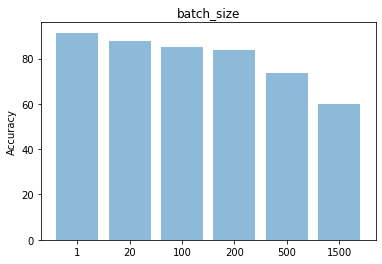

In [13]:
objects = batch_sizes
y_pos = np.arange(len(objects))
performance = model_results
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('batch_size')
 
plt.show()

### Study the impact of varying two hyper parameters

In [14]:
mini_training_data = np.random.choice(train_data_list, 1500, replace = False)
print("Percentage of training data used:", (len(mini_training_data)/len(train_data_list)) * 100)

print("This will take a few moments ...")
n_list = []
batch_sizes = [1, 20, 100, 200, 500, len(mini_training_data)]
hidden_nodes = [200, 5] # lets try two different configurations of hidden node layer

# lets create the set of modesl
for hidden in hidden_nodes:
    n_list_element = [] # first set of nets with a given hidden node size
    
    for batch in batch_sizes:
        n = neuralNetwork(batch_size=batch, hiddennodes=hidden)
        X_train, y_train = preprocess_data(mini_training_data)
        n.train(X_train, y_train)
        n_list_element.append(n)
        pass
    
    n_list.append(n_list_element)# now append the set of models 
    pass

#lets test the models 
#iterate through each model and accumilate number of correct predictions
model_results = []
model_result_element = []

for model1 in n_list:
    model_result_element = []
    
    for model2 in model1:
        correct = 0
        model2.test(X_test, y_test)
        
        for result in model2.results:
           
            if (result[0] == result[1]): 
                correct +=1
            pass
        correct = 100 * (correct / len(model2.results))
        model_result_element.append(correct)
        print(correct)
        pass
    pass
    model_results.append(model_result_element)
    pass



Percentage of training data used: 2.5
This will take a few moments ...
Training epoch#:  0
errors (SSE):  [527.9584088]
Training epoch#:  1
errors (SSE):  [258.562412]
Training epoch#:  2
errors (SSE):  [182.18867843]
Training epoch#:  3
errors (SSE):  [133.70067153]
Training epoch#:  4
errors (SSE):  [100.49332577]
Training epoch#:  5
errors (SSE):  [76.43958035]
Training epoch#:  6
errors (SSE):  [58.64913243]
Training epoch#:  7
errors (SSE):  [45.56389688]
Training epoch#:  8
errors (SSE):  [35.94115581]
Training epoch#:  9
errors (SSE):  [28.84890364]
Training epoch#:  0
errors (SSE):  [869.72167607]
Training epoch#:  1
errors (SSE):  [499.74509017]
Training epoch#:  2
errors (SSE):  [421.10443149]
Training epoch#:  3
errors (SSE):  [379.1951482]
Training epoch#:  4
errors (SSE):  [351.45251558]
Training epoch#:  5
errors (SSE):  [330.9912041]
Training epoch#:  6
errors (SSE):  [314.8882419]
Training epoch#:  7
errors (SSE):  [301.64728937]
Training epoch#:  8
errors (SSE):  [290.

## Plot the results of hidden nodes versus batch size

In the graph below we have plotted the accuracy for 6 different batch sizes comparing against 2 architectures (one with 200 hidden nodes and the other with 4 hidden nodes). 
As expected when the ANN architecture has fewer hidden nodes it has less oppertunity to learn a sensible mapping between the input features and expected outputs. 

[91.23, 87.7, 84.95, 82.24000000000001, 75.18, 62.71]
[61.839999999999996, 26.540000000000003, 17.84, 10.18, 8.92, 9.59]


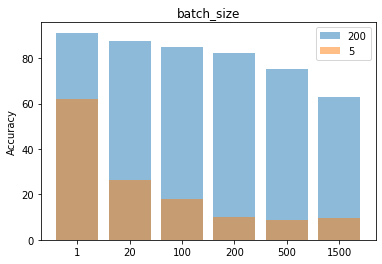

In [15]:
objects = batch_sizes

y_pos = np.arange(len(objects))
performance1 = model_results[0]
performance2 = model_results[1]
print(performance1) 
print(performance2)
plt.bar(y_pos, performance1, align='center', alpha=0.5 )
plt.bar(y_pos, performance2, align='center', alpha=0.5)

plt.legend(hidden_nodes)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('batch_size')
 
plt.show()

# Exercise

How would you interpret the results from the graph above?

You should now try exploring with different hyper-parameters: 

- What is the effect of increasing learning rate on accuracy?
- What happens to network error with increased number of epochs?
- What is the effect of increasing training epochs on test set accuracy?
- What happens to accuracy when you increase batch size?
- What is the effect of increasing the nummber of hidden layer nodes on accuracy?
- Explore the different charting functionality provided by matplotlib (https://matplotlib.org/)

Try to examine the neuralNetwork class closely:
- Can you understand how the gradients are used to tweak the weights so as to move towards a local minima of reducing error?
- You might want to write a helper function to compare the hidden_inputs values and the hidden_outputs after the activation function is applied in the query function.
- Pay attention to the training time when you use the entire 6000 instances versus a smaller sample such as 1500.
- In our lecture we covered softmax which was a method to normalise the final_outputs. Examine the  self.activation_function and try to explore the possibility of it to generate the softmax values. 


## Learning Rate 

In [36]:
mini_training_data = np.random.choice(train_data_list, 1500, replace = False)
print("Percentage of training data used:", (len(mini_training_data)/len(train_data_list)) * 100)
X_train, y_train = preprocess_data(mini_training_data)

print("This will take a few moments ...")
n_list = []
lrs = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]

for lr in lrs:
    n = neuralNetwork(learningrate=lr) # create a new ANN model with a specific learning rate
    n.train(X_train, y_train)
    n_list.append(n) # maintain each ANN model in a list


Percentage of training data used: 2.5
This will take a few moments ...
Training epoch#:  0
errors (SSE):  [2872.92457221]
Training epoch#:  1
errors (SSE):  [2430.97876487]
Training epoch#:  2
errors (SSE):  [2108.33641769]
Training epoch#:  3
errors (SSE):  [1883.0879797]
Training epoch#:  4
errors (SSE):  [1726.95972973]
Training epoch#:  5
errors (SSE):  [1616.9385511]
Training epoch#:  6
errors (SSE):  [1537.29807045]
Training epoch#:  7
errors (SSE):  [1477.91662951]
Training epoch#:  8
errors (SSE):  [1432.33883109]
Training epoch#:  9
errors (SSE):  [1396.39536698]
Training epoch#:  0
errors (SSE):  [2673.21516444]
Training epoch#:  1
errors (SSE):  [1494.47708051]
Training epoch#:  2
errors (SSE):  [1313.22147898]
Training epoch#:  3
errors (SSE):  [1233.59988557]
Training epoch#:  4
errors (SSE):  [1175.54760863]
Training epoch#:  5
errors (SSE):  [1125.84657752]
Training epoch#:  6
errors (SSE):  [1081.133989]
Training epoch#:  7
errors (SSE):  [1040.33979777]
Training epoch#

17.25
62.5
85.91
88.64999999999999
91.75999999999999
87.55


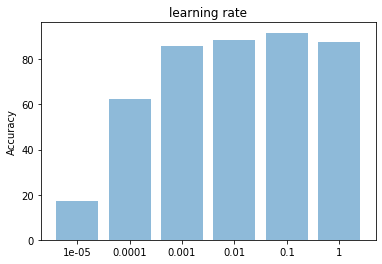

In [37]:
model_results = []
for model in n_list: 
    correct = 0
    model.test(X_test, y_test)
    for result in model.results:
        if (result[0] == result[1]):
                correct += 1
        pass
    correct = 100 * (correct/len(model.results))
    model_results.append(correct)
    print(correct)
    pass
pass

objects = lrs
y_pos = np.arange(len(objects))
performance = model_results
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('learning rate')
 
plt.show()

## Error and Test Accuracy by epochs

In [38]:
mini_training_data = np.random.choice(train_data_list, 1500, replace = False)
print("Percentage of training data used:", (len(mini_training_data)/len(train_data_list)) * 100)
X_train, y_train = preprocess_data(mini_training_data)

print("This will take a few moments ...")
n_list = []
epochs = [10,25, 50, 100, 250]

for epoch in epochs:
    n = neuralNetwork(epochs=epoch) # create a new ANN model with a specific learning rate
    n.train(X_train, y_train)
    n_list.append(n) # maintain each ANN model in a list
   
model_losses = []
for model in n_list:
    model_losses.append(model.E[-1][0])
    pass
pass

Percentage of training data used: 2.5
This will take a few moments ...
Training epoch#:  0
errors (SSE):  [529.72578484]
Training epoch#:  1
errors (SSE):  [258.40980164]
Training epoch#:  2
errors (SSE):  [181.10436056]
Training epoch#:  3
errors (SSE):  [132.89174946]
Training epoch#:  4
errors (SSE):  [99.4208055]
Training epoch#:  5
errors (SSE):  [75.09985861]
Training epoch#:  6
errors (SSE):  [57.47116039]
Training epoch#:  7
errors (SSE):  [44.75763731]
Training epoch#:  8
errors (SSE):  [35.44214688]
Training epoch#:  9
errors (SSE):  [28.56096282]
Training epoch#:  0
errors (SSE):  [523.85084653]
Training epoch#:  1
errors (SSE):  [257.76040201]
Training epoch#:  2
errors (SSE):  [179.6989318]
Training epoch#:  3
errors (SSE):  [132.68490901]
Training epoch#:  4
errors (SSE):  [100.00682606]
Training epoch#:  5
errors (SSE):  [76.78781628]
Training epoch#:  6
errors (SSE):  [59.36379818]
Training epoch#:  7
errors (SSE):  [45.87527168]
Training epoch#:  8
errors (SSE):  [36.5

errors (SSE):  [0.93616062]
Training epoch#:  81
errors (SSE):  [0.92368267]
Training epoch#:  82
errors (SSE):  [0.91161932]
Training epoch#:  83
errors (SSE):  [0.89995759]
Training epoch#:  84
errors (SSE):  [0.88868241]
Training epoch#:  85
errors (SSE):  [0.87777721]
Training epoch#:  86
errors (SSE):  [0.86722497]
Training epoch#:  87
errors (SSE):  [0.85700913]
Training epoch#:  88
errors (SSE):  [0.84711401]
Training epoch#:  89
errors (SSE):  [0.83752461]
Training epoch#:  90
errors (SSE):  [0.82822606]
Training epoch#:  91
errors (SSE):  [0.81920303]
Training epoch#:  92
errors (SSE):  [0.81043975]
Training epoch#:  93
errors (SSE):  [0.80192053]
Training epoch#:  94
errors (SSE):  [0.79363028]
Training epoch#:  95
errors (SSE):  [0.78555486]
Training epoch#:  96
errors (SSE):  [0.7776812]
Training epoch#:  97
errors (SSE):  [0.76999723]
Training epoch#:  98
errors (SSE):  [0.76249178]
Training epoch#:  99
errors (SSE):  [0.75515445]
Training epoch#:  0
errors (SSE):  [542.37

errors (SSE):  [0.53516024]
Training epoch#:  148
errors (SSE):  [0.53153171]
Training epoch#:  149
errors (SSE):  [0.52794444]
Training epoch#:  150
errors (SSE):  [0.52440468]
Training epoch#:  151
errors (SSE):  [0.52091811]
Training epoch#:  152
errors (SSE):  [0.5174896]
Training epoch#:  153
errors (SSE):  [0.51412308]
Training epoch#:  154
errors (SSE):  [0.51082144]
Training epoch#:  155
errors (SSE):  [0.50758656]
Training epoch#:  156
errors (SSE):  [0.50441921]
Training epoch#:  157
errors (SSE):  [0.50131908]
Training epoch#:  158
errors (SSE):  [0.49828492]
Training epoch#:  159
errors (SSE):  [0.4953148]
Training epoch#:  160
errors (SSE):  [0.49240645]
Training epoch#:  161
errors (SSE):  [0.4895575]
Training epoch#:  162
errors (SSE):  [0.48676561]
Training epoch#:  163
errors (SSE):  [0.48402854]
Training epoch#:  164
errors (SSE):  [0.48134412]
Training epoch#:  165
errors (SSE):  [0.47871024]
Training epoch#:  166
errors (SSE):  [0.47612486]
Training epoch#:  167
err

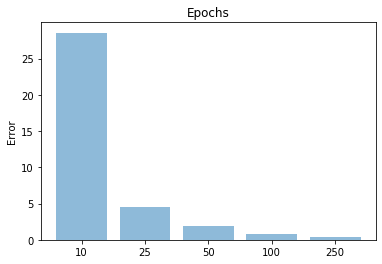

91.93
92.65
92.7
92.9
92.39


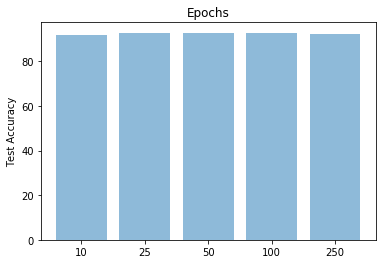

In [39]:
objects = epochs
y_pos = np.arange(len(objects))
performance = model_losses
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Error')
plt.title('Epochs')
 
plt.show()

model_results = []
for model in n_list: 
    correct = 0
    model.test(X_test, y_test)
    for result in model.results:
        if (result[0] == result[1]):
                correct += 1
        pass
    correct = 100 * (correct/len(model.results))
    model_results.append(correct)
    print(correct)
    pass
pass

objects = epochs
y_pos = np.arange(len(objects))
performance = model_results
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Test Accuracy')
plt.title('Epochs')
 
plt.show()

## Hidden Nodes

In [40]:
mini_training_data = np.random.choice(train_data_list, 1500, replace = False)
print("Percentage of training data used:", (len(mini_training_data)/len(train_data_list)) * 100)
X_train, y_train = preprocess_data(mini_training_data)

print("This will take a few moments ...")
n_list = []
hidden_nodes = [50, 100, 200, 400, 800]

for nodes in hidden_nodes:
    n = neuralNetwork(hiddennodes=nodes) # create a new ANN model with a specific learning rate
    n.train(X_train, y_train)
    n_list.append(n) # maintain each ANN model in a list


Percentage of training data used: 2.5
This will take a few moments ...
Training epoch#:  0
errors (SSE):  [637.60332759]
Training epoch#:  1
errors (SSE):  [336.08897303]
Training epoch#:  2
errors (SSE):  [250.48831579]
Training epoch#:  3
errors (SSE):  [199.16669566]
Training epoch#:  4
errors (SSE):  [161.41156317]
Training epoch#:  5
errors (SSE):  [132.43513378]
Training epoch#:  6
errors (SSE):  [109.79518757]
Training epoch#:  7
errors (SSE):  [92.2535493]
Training epoch#:  8
errors (SSE):  [78.25281933]
Training epoch#:  9
errors (SSE):  [66.92400389]
Training epoch#:  0
errors (SSE):  [538.01288958]
Training epoch#:  1
errors (SSE):  [285.67656871]
Training epoch#:  2
errors (SSE):  [209.92732221]
Training epoch#:  3
errors (SSE):  [161.89655401]
Training epoch#:  4
errors (SSE):  [127.41902614]
Training epoch#:  5
errors (SSE):  [101.33971555]
Training epoch#:  6
errors (SSE):  [81.51194042]
Training epoch#:  7
errors (SSE):  [66.07946349]
Training epoch#:  8
errors (SSE):  

89.92
90.53999999999999
91.14
91.62
91.86


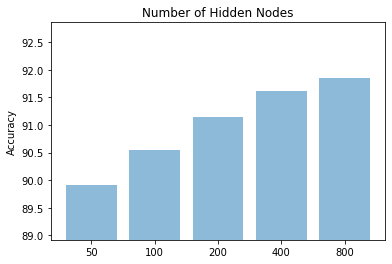

In [42]:
model_results = []
for model in n_list: 
    correct = 0
    model.test(X_test, y_test)
    for result in model.results:
        if (result[0] == result[1]):
                correct += 1
        pass
    correct = 100 * (correct/len(model.results))
    model_results.append(correct)
    print(correct)
    pass
pass

objects = hidden_nodes
y_pos = np.arange(len(objects))
performance = model_results
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylim(min(performance)-1, max(performance)+1)
plt.ylabel('Accuracy')
plt.title('Number of Hidden Nodes')
 
plt.show()

# Compare before and after activations

In [68]:
mini_training_data = np.random.choice(train_data_list, 1500, replace = False)
print("Percentage of training data used:", (len(mini_training_data)/len(train_data_list)) * 100)
X_train, y_train = preprocess_data(mini_training_data)

n = neuralNetwork(compare_enabled=True)
n.train(X_train, y_train)

Percentage of training data used: 2.5
Training epoch#:  0
errors (SSE):  [546.23539347]
Training epoch#:  1
errors (SSE):  [264.6763748]
Training epoch#:  2
errors (SSE):  [185.30147202]
Training epoch#:  3
errors (SSE):  [138.55691885]
Training epoch#:  4
errors (SSE):  [105.69291093]
Training epoch#:  5
errors (SSE):  [81.31185893]
Training epoch#:  6
errors (SSE):  [62.98244829]
Training epoch#:  7
errors (SSE):  [49.20634179]
Training epoch#:  8
errors (SSE):  [38.97516703]
Training epoch#:  9
errors (SSE):  [31.62495723]


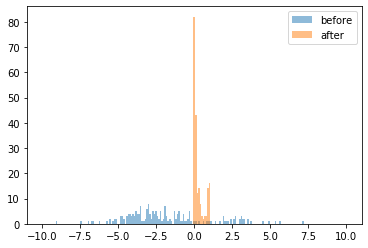

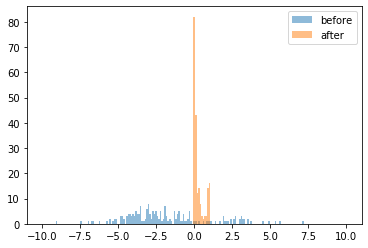

In [69]:
n.test(X_test[:1], y_test[:1])

bins = np.linspace(-10, 10, 200)

plt.hist(n.before_act[0], bins, alpha=0.5, label='before')
plt.hist(n.after_act[0], bins, alpha=0.5, label='after')
plt.legend(loc='upper right')
plt.show()

n.test(X_test[1:2], y_test[1:2])

bins = np.linspace(-10, 10, 200)

plt.hist(n.before_act[0], bins, alpha=0.5, label='before')
plt.hist(n.after_act[0], bins, alpha=0.5, label='after')
plt.legend(loc='upper right')
plt.show()

# Training Time

In [72]:
import datetime

mini_training_data = np.random.choice(train_data_list, 1500, replace = False)
print("Percentage of training data used:", (len(mini_training_data)/len(train_data_list)) * 100)
X_train, y_train = preprocess_data(mini_training_data)

before = datetime.datetime.now()
n = neuralNetwork(compare_enabled=True)
n.train(X_train, y_train)
after = datetime.datetime.now()
print('Time taken for training data size 1500 : ', after-before)

mini_training_data = np.random.choice(train_data_list, 6000, replace = False)
print("Percentage of training data used:", (len(mini_training_data)/len(train_data_list)) * 100)
X_train, y_train = preprocess_data(mini_training_data)

before = datetime.datetime.now()
n = neuralNetwork(compare_enabled=True)
n.train(X_train, y_train)
after = datetime.datetime.now()
print('Time taken for training data size 6000 : ', after-before)

Percentage of training data used: 2.5
Training epoch#:  0
errors (SSE):  [523.59390238]
Training epoch#:  1
errors (SSE):  [254.4397533]
Training epoch#:  2
errors (SSE):  [176.32309502]
Training epoch#:  3
errors (SSE):  [130.22141009]
Training epoch#:  4
errors (SSE):  [98.56818663]
Training epoch#:  5
errors (SSE):  [76.58411295]
Training epoch#:  6
errors (SSE):  [59.89692007]
Training epoch#:  7
errors (SSE):  [47.22802771]
Training epoch#:  8
errors (SSE):  [37.72976143]
Training epoch#:  9
errors (SSE):  [30.66448346]
Time taken for training data size 1500 :  0:00:06.975471
Percentage of training data used: 10.0
Training epoch#:  0
errors (SSE):  [1367.13977373]
Training epoch#:  1
errors (SSE):  [705.76617833]
Training epoch#:  2
errors (SSE):  [513.95188509]
Training epoch#:  3
errors (SSE):  [395.8520381]
Training epoch#:  4
errors (SSE):  [310.23246347]
Training epoch#:  5
errors (SSE):  [245.97836934]
Training epoch#:  6
errors (SSE):  [197.51725153]
Training epoch#:  7
err